In [2]:
%matplotlib inline

import functools
from itertools import izip
import os
import datetime

from IPython.core.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import pysam
import scipy.stats
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from clipper.src import CLIP_analysis
from gscripts import qtools
from gscripts.encode import encode_helpers
from gscripts.general import dataviz
from gscripts.rnaseq import splicing_map

tqdm.pandas(desc="Progress")
sns.set_style("ticks")
img_dir = "/home/gpratt/Dropbox/Pratt_Gabriel/PapersInProgress/eCLIP_qc/working_figures/fig_2/"

In [3]:
merged_data = encode_helpers.get_merged_data()

#Filter out anything sequenced after 16/7/18
merged_data = merged_data[merged_data['Submitted Date'] < datetime.date(2016, 7, 18)]
#Filter out anything not_qced
merged_data = merged_data[merged_data.is_qced]

# Load in the entropy for all the repetitive elements

/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/20170228_parsedoutput.ALLdatasets.csv.nopipes.csv

I can try some slightly more complicated machine learning approaches here, not just a generative model, but some simple descriminative ones as well

In [5]:
rep_elements = pd.read_table("/home/elvannostrand/data/clip/CLIPseq_analysis/scripts/inline_processing/20170505.ALLENCODEinclnotsubmitted.txt.nopipes.txt",
                            header=0, names= ["element", "file","something", "clip_count", "clip_rpr", "input_count", "input_rpr", "fold-enrichment", "information content"])

# Clean Data, take only datasets that pass min read threshold and read level cutoff

In [6]:
merged_data['ip_raw_names'] = merged_data.CLIP.apply(lambda x: os.path.basename(x).split(".")[0])
rep_elements = rep_elements[rep_elements.file.isin(merged_data['ip_raw_names'].values)]


In [11]:
rep_elements[rep_elements.file.apply(lambda x: "POLR2G" in x)].sort_values("information content", ascending=False)

,element,file,something,clip_count,clip_rpr,input_count,input_rpr,fold-enrichment,information content
34168,unique_distintron,417_01_POLR2G,POLR2G-K562_01,1575544,0.131681,526776,0.025554,5.152965,0.311479
34216,unique_distintron,484_01_POLR2G,POLR2G-HepG2_01,1251322,0.152659,724772,0.046610,3.275250,0.261292
57004,antisense_L1,417_01_POLR2G,POLR2G-K562_01,881138,0.073644,162374,0.007877,9.349320,0.237492
34169,unique_distintron,417_02_POLR2G,POLR2G-K562_02,1150104,0.110428,526776,0.025554,4.321268,0.233163
99216,antisense_Alu,417_01_POLR2G,POLR2G-K562_01,745646,0.062320,177825,0.008626,7.224245,0.177789
57005,antisense_L1,417_02_POLR2G,POLR2G-K562_02,581207,0.055805,162374,0.007877,7.084584,0.157631
34217,unique_distintron,484_02_POLR2G,POLR2G-HepG2_02,782306,0.110245,724772,0.046610,2.365268,0.136925
99265,antisense_Alu,484_02_POLR2G,POLR2G-HepG2_02,406718,0.057316,171561,0.011033,5.194933,0.136246
99217,antisense_Alu,417_02_POLR2G,POLR2G-K562_02,526481,0.050550,177825,0.008626,5.859896,0.128947
99264,antisense_Alu,484_01_POLR2G,POLR2G-HepG2_01,426219,0.051998,171561,0.011033,4.712931,0.116300


In [7]:
rep_elements[rep_elements.file.apply(lambda x: "FXR1" in x)].sort_values("information content", ascending=False)

,element,file,something,clip_count,clip_rpr,input_count,input_rpr,fold-enrichment,information content
39045,unique_CDS,315_02_FXR1,FXR1-K562_02,1938144,0.236944,76380,0.031132,7.610890,0.693787
39056,unique_CDS,300_01_FXR1,FXR1-HepG2_01,801873,0.179069,685696,0.044214,4.050088,0.361353
39044,unique_CDS,315_01_FXR1,FXR1-K562_01,1074989,0.147978,76380,0.031132,4.753214,0.332788
39057,unique_CDS,300_02_FXR1,FXR1-HepG2_02,144988,0.097696,685696,0.044214,2.209639,0.111746
125556,RNA18S,300_01_FXR1,FXR1-HepG2_01,730445,0.163118,1751112,0.112911,1.444655,0.086571
38365,RNA28S,300_02_FXR1,FXR1-HepG2_02,501096,0.337649,4644894,0.299502,1.127369,0.058400
111013,unique_3utr,315_02_FXR1,FXR1-K562_02,398020,0.048659,62505,0.025477,1.909938,0.045425
32125,unique_5utr,315_02_FXR1,FXR1-K562_02,133367,0.016305,11717,0.004776,3.413980,0.028883
111012,unique_3utr,315_01_FXR1,FXR1-K562_01,297439,0.040944,62505,0.025477,1.607112,0.028025
111024,unique_3utr,300_01_FXR1,FXR1-HepG2_01,116867,0.026098,273428,0.017631,1.480265,0.014768


In [8]:
rep_elements[rep_elements.file.apply(lambda x: "FXR2" in x)].sort_values("information content", ascending=False)

,element,file,something,clip_count,clip_rpr,input_count,input_rpr,fold-enrichment,information content
39034,unique_CDS,237_01_FXR2,FXR2-K562_01,1087535,0.255203,262000,0.029297,8.710850,0.796950
39035,unique_CDS,237_02_FXR2,FXR2-K562_02,873371,0.160726,262000,0.029297,5.486072,0.394706
111002,unique_3utr,237_01_FXR2,FXR2-K562_01,282749,0.066350,135245,0.015123,4.387311,0.141548
125535,RNA18S,237_02_FXR2,FXR2-K562_02,943385,0.173611,1113679,0.124533,1.394097,0.083217
32114,unique_5utr,237_01_FXR2,FXR2-K562_01,144128,0.033821,56140,0.006278,5.387590,0.082174
32115,unique_5utr,237_02_FXR2,FXR2-K562_02,89027,0.016384,56140,0.006278,2.609837,0.022674
125534,RNA18S,237_01_FXR2,FXR2-K562_01,579784,0.136053,1113679,0.124533,1.092508,0.017366
111003,unique_3utr,237_02_FXR2,FXR2-K562_02,112568,0.020716,135245,0.015123,1.369802,0.009404
89550,Simple_repeat,237_01_FXR2,FXR2-K562_01,31556,0.007405,32285,0.003610,2.051161,0.007675
23118,Low_complexity,237_01_FXR2,FXR2-K562_01,18689,0.004386,14223,0.001590,2.757487,0.006418


In [9]:
rep_elements[rep_elements.file.apply(lambda x: "FMR" in x)].sort_values("information content", ascending=False)

,element,file,something,clip_count,clip_rpr,input_count,input_rpr,fold-enrichment,information content
38863,unique_CDS,236_02_FMR1,FMR1-K562_02,962067,0.247943,260989,0.031413,7.892893,0.739008
38862,unique_CDS,236_01_FMR1,FMR1-K562_01,776208,0.191632,260989,0.031413,6.100320,0.499947
31942,unique_5utr,236_01_FMR1,FMR1-K562_01,122273,0.030187,51195,0.006162,4.898913,0.069203
76923,unique_intergenic,236_02_FMR1,FMR1-K562_02,106702,0.027499,54593,0.006571,4.184935,0.056791
31943,unique_5utr,236_02_FMR1,FMR1-K562_02,100893,0.026002,51195,0.006162,4.219749,0.054010
110831,unique_3utr,236_02_FMR1,FMR1-K562_02,151601,0.039070,142956,0.017207,2.270664,0.046225
110830,unique_3utr,236_01_FMR1,FMR1-K562_01,148310,0.036615,142956,0.017207,2.127966,0.039891
85919,unique_noncoding_exon,236_02_FMR1,FMR1-K562_02,93743,0.024159,73507,0.008848,2.730633,0.035013
78307,unique_antisense_gencode,236_02_FMR1,FMR1-K562_02,41581,0.010716,23466,0.002824,3.794102,0.020615
29867,unique_proxintron,236_02_FMR1,FMR1-K562_02,128296,0.033064,207059,0.024922,1.326698,0.013485


# Get a sense of whats going on, plot the distributions

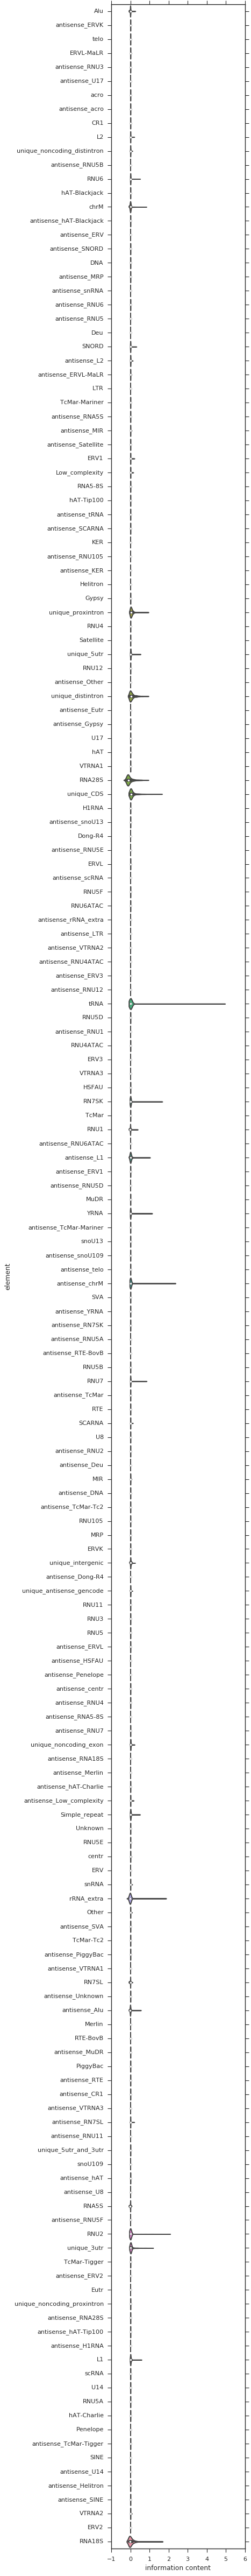

In [8]:
num_cols = 2
num_rows = 20
with dataviz.Figure(os.path.join(img_dir, "entropy_metrics.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.violinplot(x="information content", y="element", data=rep_elements,
                   scale="width", cut=True, ax=ax)

In [9]:
import json
import gspread
from oauth2client.client import SignedJwtAssertionCredentials


json_key = json.load(open("/home/gpratt/ipython_notebook/public clip-588adbc137f3.json"))
scope = ['https://spreadsheets.google.com/feeds']

credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
gc = gspread.authorize(credentials)

sht1 = gc.open_by_url("https://docs.google.com/spreadsheets/d/1NMjzbneXf8bGN13K9azoqK2YbMCrjQqfJBKFoCkkrtY/edit#gid=0")
ws = sht1.worksheet("Sheet2")
list_of_lists = ws.get_all_values()
rep_element_annotations = pd.DataFrame(list_of_lists[1:], columns=list_of_lists[0])
rep_element_annotations.interesting = [item == "TRUE" for item in rep_element_annotations.interesting]
rep_element_annotations.checked = [item == "TRUE" for item in rep_element_annotations.checked]

rep_element_annotations = rep_element_annotations[rep_element_annotations.interesting]
#rep_element_annotations = rep_element_annotations[~rep_element_annotations.checked]

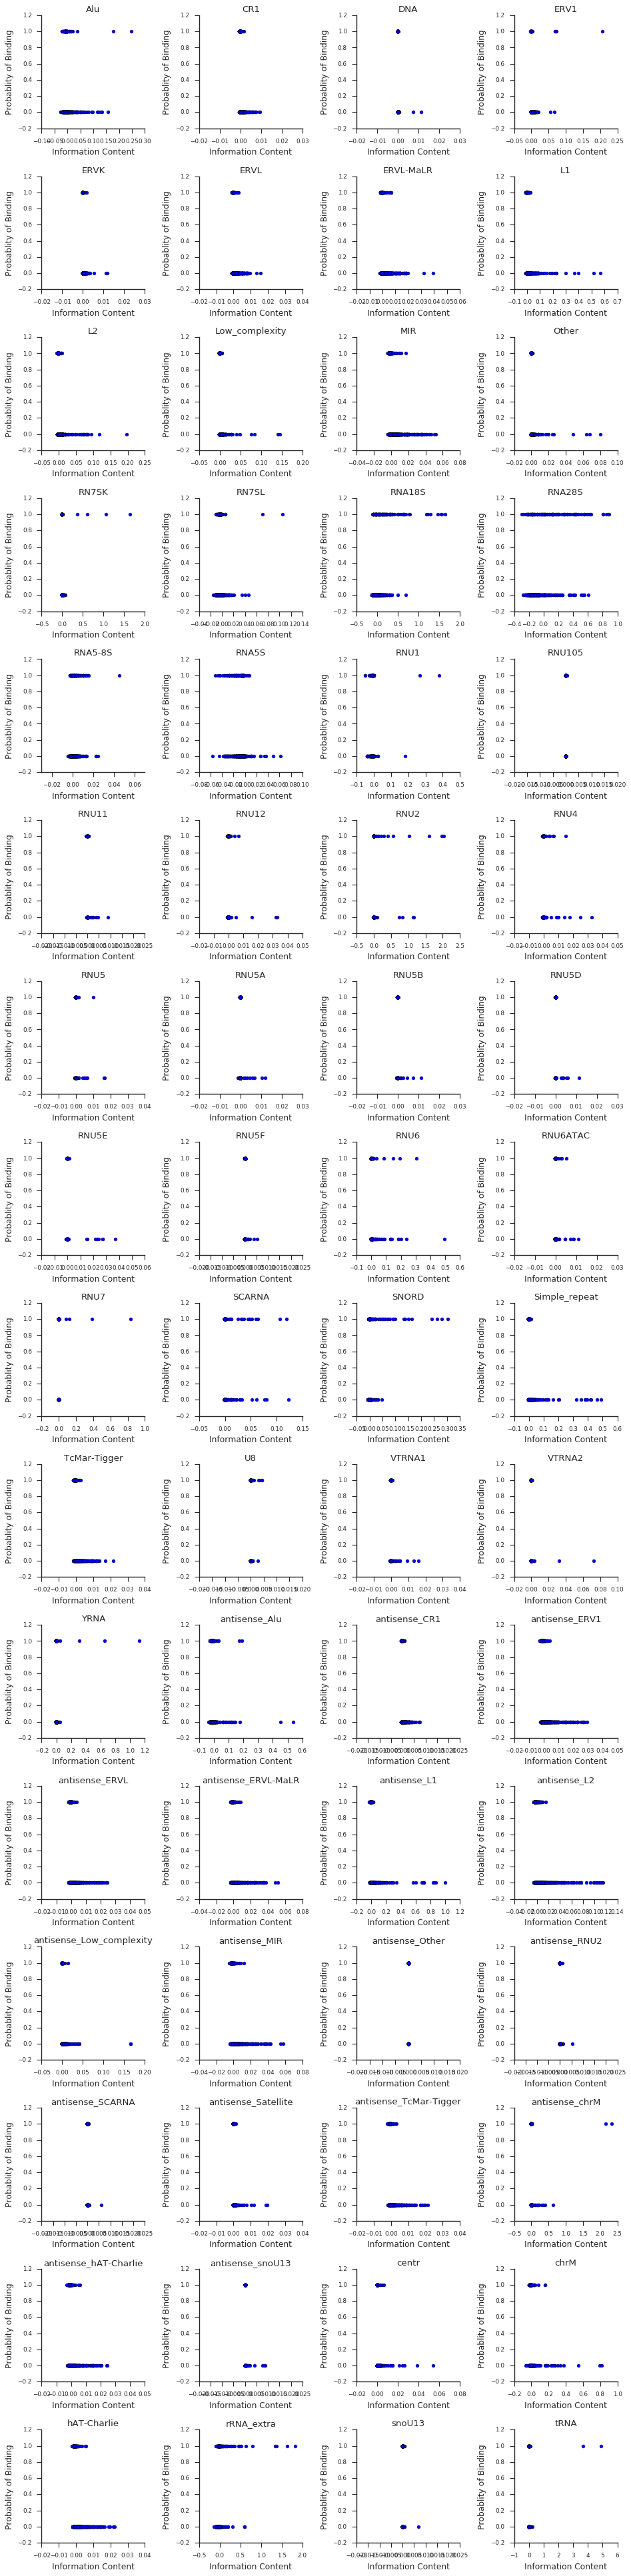

In [10]:
grp = rep_elements.groupby("element")

num_cols = 4
num_rows = (len(rep_element_annotations.Family) / 4) + 1
with dataviz.Figure(os.path.join(img_dir, "entropy_metrics.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    for x, family in enumerate(rep_element_annotations.Family):
        df = grp.get_group(family)
        ax = fig.add_subplot(num_rows, num_cols, x+  1)
        
        df = pd.merge(merged_data, df, left_on="ip_raw_names", right_on="file")
        ax.scatter(df['information content'], df.family_mapping_submitable)
        ax.set_title(family)
        ax.set_ylabel("Probablity of Binding")
        ax.set_xlabel("Information Content")
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

        sns.despine(ax=ax)

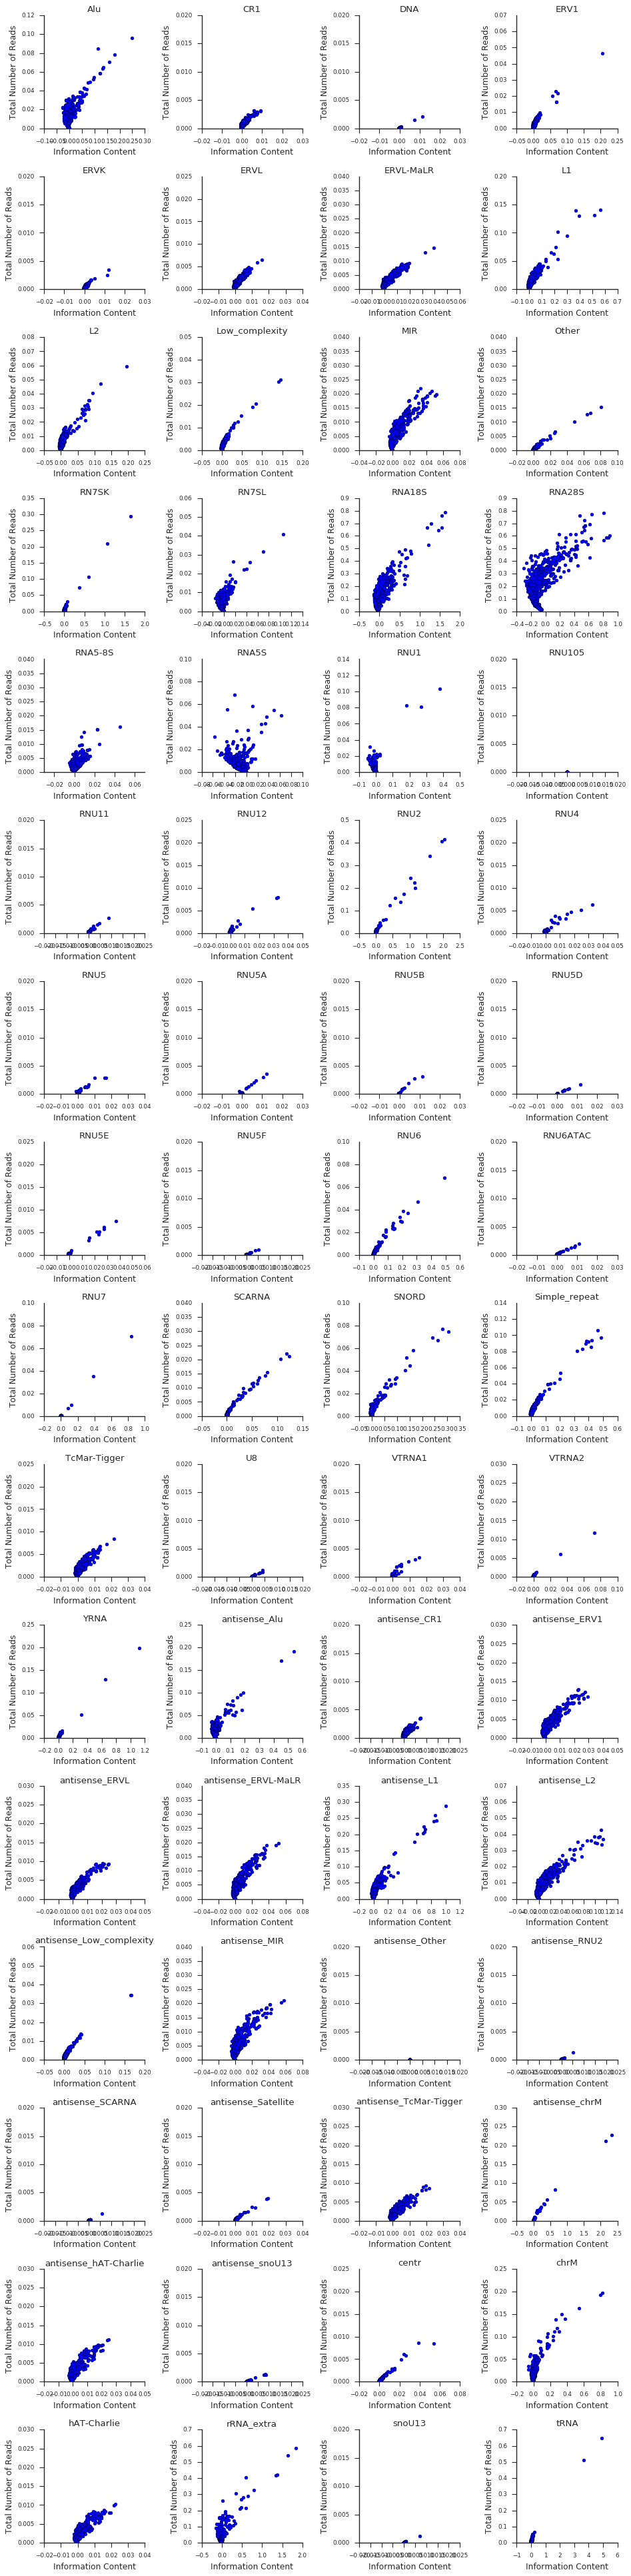

In [11]:
grp = rep_elements.groupby("element")

num_cols = 4
num_rows = (len(rep_element_annotations.Family) / 4) + 1
with dataviz.Figure(os.path.join(img_dir, "entropy_metrics.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    for x, family in enumerate(rep_element_annotations.Family):
        df = grp.get_group(family)
        ax = fig.add_subplot(num_rows, num_cols, x+  1)
        
        df = pd.merge(merged_data, df, left_on="ip_raw_names", right_on="file")
        ax.scatter(df['information content'], df.clip_rpr)
        ax.set_title(family)
        ax.set_ylabel("Total Number of Reads")
        ax.set_xlabel("Information Content")
        ax.set_ylim(0,)
        [tick.set_fontsize(8) for tick in ax.get_xticklabels()]
        [tick.set_fontsize(8) for tick in ax.get_yticklabels()]

        sns.despine(ax=ax)

In [12]:
df = grp.get_group("L1")
df = pd.merge(merged_data, df, left_on="ip_raw_names", right_on="file")
df.sort_values("information content", ascending=False)

CLIP,CLIP,,INPUT,Submitted Date,annotation,family,family_bound,family_mapping_submitable,is_qced,note,...,ip_raw_names,element,file,something,clip_count,clip_rpr,input_count,input_rpr,fold-enrichment,information content
83,/projects/ps-yeolab3/encode/analysis/encode_ma...,DSCR4 - rolling hill intron binding; other top...,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-05-06,,L1,TRUE,False,True,,...,267_02_SAFB2,L1,267_02_SAFB2,SAFB2-K562_02,1718326,0.140337,132574,0.008550,16.413680,0.566515
82,/projects/ps-yeolab3/encode/analysis/encode_ma...,DSCR4 - rolling hill intron binding; other top...,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-05-06,,L1,TRUE,False,True,,...,267_01_SAFB2,L1,267_01_SAFB2,SAFB2-K562_01,1782831,0.131352,132574,0.008550,15.362811,0.517706
241,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-12-04,,L1,TRUE,False,True,,...,461_02_LARP4,L1,461_02_LARP4,LARP4-K562_02,360644,0.129792,166479,0.015643,8.297016,0.396202
324,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2016-02-16,,L1,TRUE,False,True,,...,522_01_HLTF,L1,522_01_HLTF,HLTF-K562_01,1064294,0.139192,81056,0.022322,6.235547,0.367539
166,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-07-26,,,FALSE,False,True,,...,353_01_KHDRBS1-SAM68,L1,353_01_KHDRBS1-SAM68,KHDRBS1-K562_01,1119472,0.094843,154474,0.010709,8.856392,0.298445
204,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2016-01-21,,,FALSE,False,True,,...,414_01_PPIL4,L1,414_01_PPIL4,PPIL4-K562_01,644010,0.053551,41959,0.002906,18.425335,0.225108
325,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2016-02-16,,L1,TRUE,False,True,,...,522_02_HLTF,L1,522_02_HLTF,HLTF-K562_02,849786,0.102106,81056,0.022322,4.574155,0.223970
167,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-07-26,,,FALSE,False,True,,...,353_02_KHDRBS1-SAM68,L1,353_02_KHDRBS1-SAM68,KHDRBS1-K562_02,1029711,0.074315,154474,0.010709,6.939496,0.207698
104,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2015-06-11,Submit,,FALSE,False,True,submittable,...,290_01_CPSF6,L1,290_01_CPSF6,CPSF6-HepG2_01,66264,0.062613,124090,0.007516,8.330911,0.191499
492,/projects/ps-yeolab3/encode/analysis/encode_ma...,,/projects/ps-yeolab3/encode/analysis/encode_ma...,2016-05-09,Submit,,FALSE,False,True,submittable,...,651_01_HLTF,L1,651_01_HLTF,HLTF-HepG2_01,839118,0.065070,253674,0.010105,6.439215,0.174835
